# PyTorchワークフロー

参考資料: https://www.learnpytorch.io/01_pytorch_workflow/

このノートブックでは次の内容を扱います:
    
    * 1. データの準備と読み込み
    * 2. 深層学習モデルの構築
    * 3. モデルをデータに適合させる（学習）
    * 4. 予測を行いモデルを評価する（推論）
    * 5. モデルの保存と読み込み
    * 6. ワークフロー全体をまとめて実行する
    
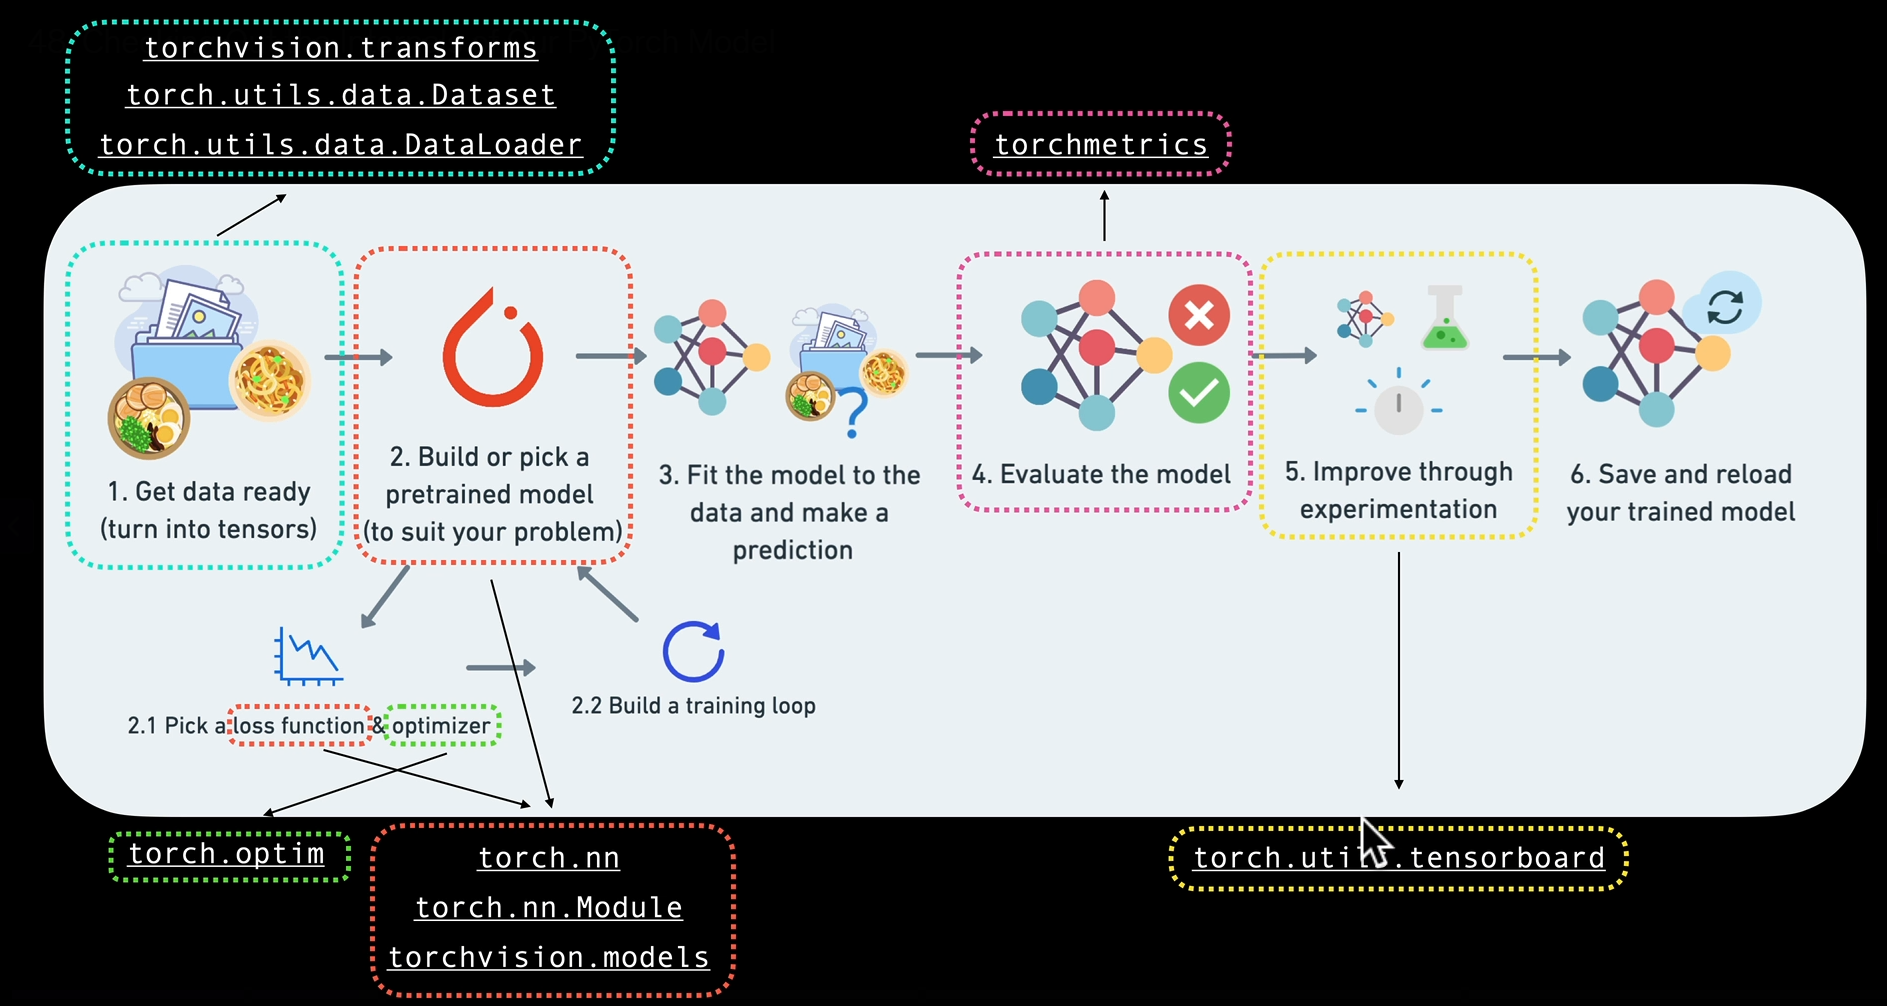

In [1]:
import torch
from torch import nn # nn にはニューラルネットワークを構築するための PyTorch の部品が揃っている
import matplotlib.pyplot as plt

torch.__version__

'2.8.0+cu126'

## 1. データの準備と読み込み

既知の**パラメータ**を使って線形回帰モデルで直線を作成するところから始めます。

In [2]:
# 既知のパラメータを定義する
weight = 0.7
bias = 0.3

# データとなる配列を作成する
X = torch.arange(0, 1, 0.02).unsqueeze(dim=1)
Y = weight*X + bias
X[:5], Y[:5]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560]]))

In [3]:
len(X), len(Y)

(50, 50)

In [4]:
# データを訓練用とテスト用に分割する

train_split = int(0.8*len(X))
X_train, Y_train = X[:train_split], Y[:train_split]
X_test, Y_test = X[train_split:], Y[train_split:]

len(X_train), len(Y_train), len(X_test), len(Y_test)

(40, 40, 10, 10)

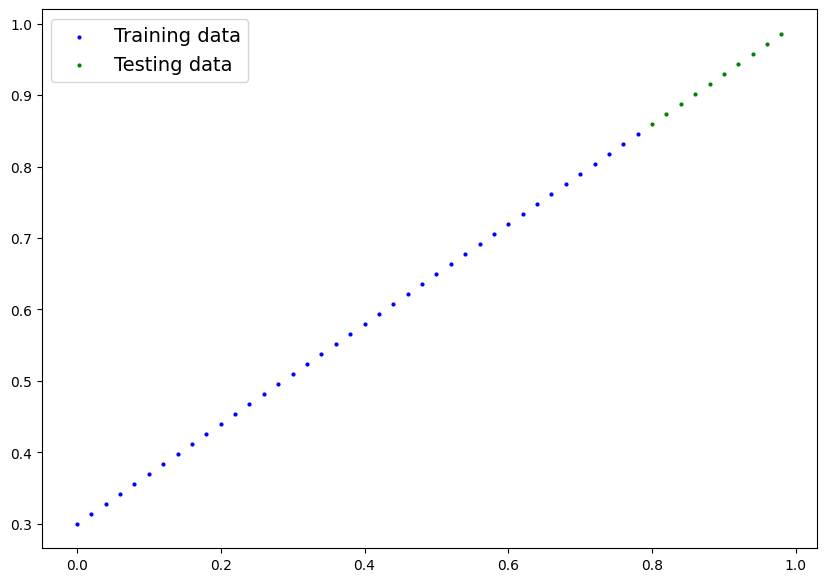

In [5]:
def plot_predictions(train_data = X_train, train_labels=Y_train,
                     test_data = X_test, test_labels=Y_test,
                     predictions = None):
    """
    訓練データとテストデータを描画し、ラベルを比較する
    """
    plt.figure(figsize=(10, 7))
    plt.scatter(train_data, train_labels, c="b", s=4, label = "Training data")
    plt.scatter(test_data, test_labels, c="g", s=4, label = "Testing data")
    
    if predictions is not None:
        plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")
    
    plt.legend(prop = {"size":14})

plot_predictions()


## 2. モデルの構築

In [6]:
# 線形回帰モデルのクラスを定義する
class LinearRegMdl(nn.Module):  # nn.Module を継承するサブクラス

    def __init__(self):
        # モデルのパラメータを初期化する
        super().__init__()
        self.weights = nn.Parameter(torch.randn(1, 
                                                requires_grad=True,
                                                dtype=torch.float))
        self.bias = nn.Parameter(torch.randn(1, 
                                            requires_grad=True,
                                            dtype=torch.float))
        
    # forward() でモデルの計算処理を定義する
    # nn.Module を継承する場合は forward() を必ず実装する
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.weights*x + self.bias  # 線形回帰モデルの計算

In [7]:
# モデルのパラメータや内部状態を確認する
torch.manual_seed(42)
model_0 = LinearRegMdl()
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [8]:
# 名前付きパラメータを一覧表示する
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

In [9]:
weight, bias

(0.7, 0.3)

In [10]:
# 'torch.inference_mode()' を使って予測を行う
# inference_mode() は勾配追跡を無効化し、計算グラフを作らない
# PyTorch の推奨されるベストプラクティス
with torch.inference_mode():
    y_preds = model_0(X_test)
    
y_preds

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])

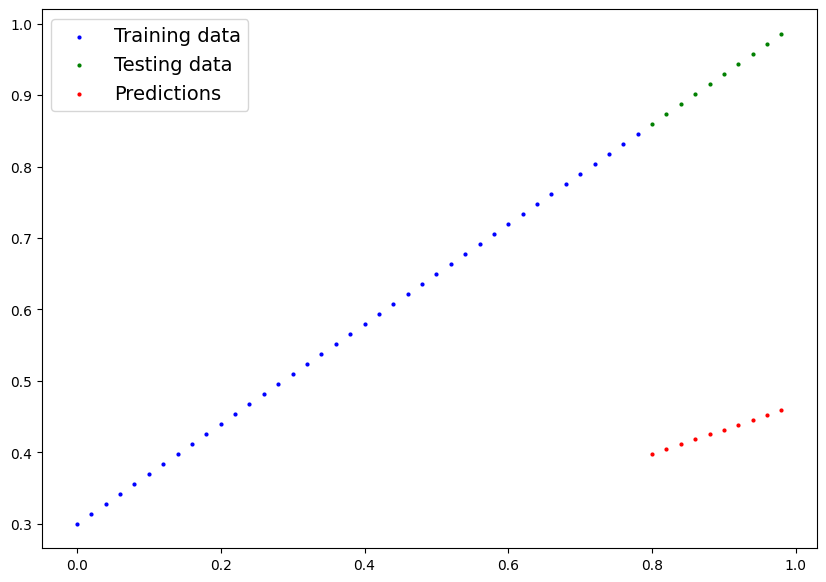

In [11]:
plot_predictions(predictions=y_preds)

## 3. モデルの学習

モデルの予測がどれだけ悪いかを測るには**損失関数**を使います。また、損失を踏まえてモデルのパラメータを更新するために最適化手法が必要です。

In [12]:
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [13]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

In [14]:
# 損失関数を設定する
loss_fn = nn.L1Loss()
# 最適化手法（確率的勾配降下法）を設定する
optimizer = torch.optim.SGD(params=model_0.parameters(), 
                            lr=0.02)  # 学習率を設定する


### トレーニングループの構築

1. フォワードパス: モデルが全訓練データを1度通過し、`model(x_train)` の計算を行う。
2. 損失の計算: モデルの出力（予測値）と正解を比較し、誤差を評価する。	``loss = loss_fn(y_pred, y_train)``
3. 勾配の初期化: 最適化器の勾配はデフォルトで蓄積されるため、特定のステップだけにするには `optimizer.zero_grad()` でリセットする。
4. 損失の逆伝播: `requires_grad=True` の各パラメータについて損失の勾配を計算する。これは「逆伝播」と呼ばれる。`loss.backward()`
5. 最適化ステップ（勾配降下）: 損失勾配に基づいて `requires_grad=True` のパラメータを更新する。`optimizer.step()`

In [ ]:
epochs = 10 # データに対する反復回数

for epoch in range(epochs):
    # モデルを学習モードに切り替える
    model_0.train()
    
    # 1. フォワードパス
    y_pred = model_0(X_train)

    # 2. 損失を計算する
    loss = loss_fn(y_pred, Y_train)
    print(f"Loss: {loss}")

    # 3. 最適化器の勾配をリセットする
    optimizer.zero_grad()

    # 4. 損失に対して逆伝播を実行してパラメータの勾配を求める
    loss.backward()

    # 5. 最適化器を進める（勾配降下を実行する）
    # デフォルトでは更新量がループ中に蓄積されるため、上でゼロクリアしておく
    optimizer.step()
    
    ## テスト
    model_0.eval() # 評価・テストに不要な設定を無効化する
    with torch.inference_mode(): # 勾配追跡を無効化する
        # 1. フォワードパスを実行する
        test_pred = model_0(X_test)

        # 2. テスト損失を計算する
        test_loss = loss_fn(test_pred, Y_test)
        
        

    print(model_0.state_dict())

Loss: 0.31288138031959534
OrderedDict([('weights', tensor([0.3445])), ('bias', tensor([0.1488]))])
Loss: 0.28983935713768005
OrderedDict([('weights', tensor([0.3523])), ('bias', tensor([0.1688]))])
Loss: 0.26679736375808716
OrderedDict([('weights', tensor([0.3601])), ('bias', tensor([0.1888]))])
Loss: 0.24375534057617188
OrderedDict([('weights', tensor([0.3679])), ('bias', tensor([0.2088]))])
Loss: 0.22071333229541779
OrderedDict([('weights', tensor([0.3757])), ('bias', tensor([0.2288]))])
Loss: 0.1976713389158249
OrderedDict([('weights', tensor([0.3835])), ('bias', tensor([0.2488]))])
Loss: 0.1746293604373932
OrderedDict([('weights', tensor([0.3913])), ('bias', tensor([0.2688]))])
Loss: 0.1515873372554779
OrderedDict([('weights', tensor([0.3991])), ('bias', tensor([0.2888]))])
Loss: 0.12854532897472382
OrderedDict([('weights', tensor([0.4069])), ('bias', tensor([0.3088]))])
Loss: 0.10609114170074463
OrderedDict([('weights', tensor([0.4147])), ('bias', tensor([0.3268]))])


In [16]:
with torch.inference_mode():
    y_pred_new = model_0(X_test)

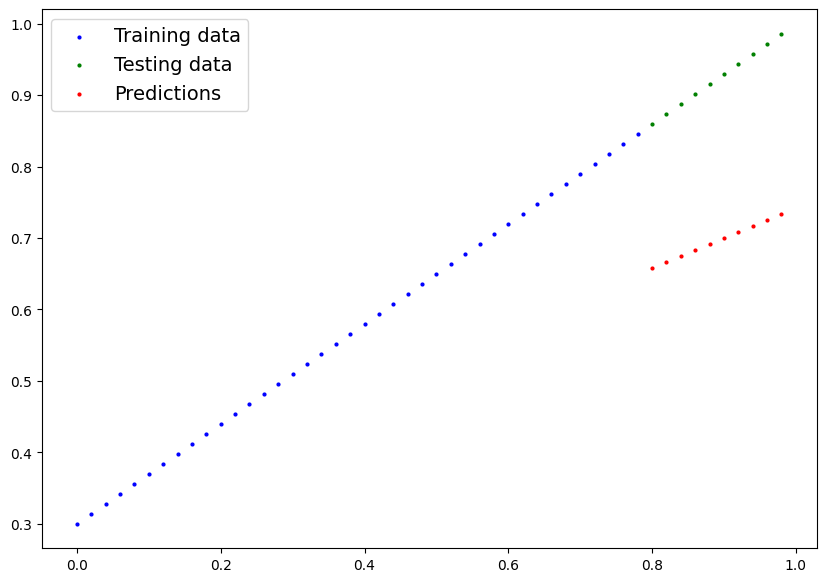

In [17]:
plot_predictions(predictions=y_pred_new)